# Modelos de mezcla {#sec-mixture}

In [1]:
#| code-fold: true

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz

In [17]:
#| code-fold: true

az.style.use('arviz-doc')

El Río de la Plata es el río más ancho de la Tierra y una frontera natural entre Argentina y Uruguay. A finales del siglo XIX, la zona portuaria a lo largo de este río era un lugar donde miembros de pueblos originarios se mezclaban con africanos (la mayoría de ellos esclavos) e inmigrantes europeos. Una consecuencia de este encuentro fue la mezcla de músicas europeas, como el vals y la mazurca, con el candombe africano y la milonga argentina (que, a su vez, es una mezcla de ritmos afroamericanos), dando origen a la danza y la música que conocemos como Tango.

Mezclar elementos previamente existentes es una excelente manera de crear cosas nuevas, no solo en el contexto de la música. En estadística, los modelos mixtos son un enfoque común para la construcción de modelos. Estos modelos se construyen mezclando distribuciones más simples para obtener otras más complejas. Por ejemplo, podemos combinar dos Gaussianas para describir una distribución bimodal o muchas Gaussianas para describir distribuciones arbitrarias. Si bien el uso de Gaussianas es muy común, en principio podemos mezclar cualquier familia de distribuciones que queramos. Los modelos mixtos se utilizan para diferentes propósitos, como modelar directamente subpoblaciones o como un *truco* para lidiar con distribuciones complejas dificiles de describir con las típicas distribuciones de probabilidad.

Los modelos de mezcla surgen naturalmente cuando la población general es una combinación de subpoblaciones distintas. Un ejemplo familiar es la distribución de alturas en una población humana adulta, que puede describirse como una mezcla de subpoblaciones femeninas y masculinas. Otro ejemplo clásico es la agrupación de dígitos escritos a mano. En este caso, es muy razonable esperar 10 subpoblaciones, ¡al menos en un sistema de base 10! 

Si sabemos a qué subpoblación pertenece cada observación, generalmente es una buena idea utilizar esa información para modelar cada subpoblación como un grupo separado. Sin embargo, cuando no tenemos acceso directo a esta información, los modelos de mezcla vienen muy bien.


Al construir un modelo mixto, no es necesario creer que estamos describiendo subpoblaciones reales en los datos. Los modelos mixtos también se pueden utilizar como un truco estadístico para agregar flexibilidad a nuestra caja de herramientas. Tomemos, por ejemplo, la distribución Gaussiana. Podemos usar esta distribución como un aproximación razonable para muchas distribuciones unimodales y aproximadamente simétricas, incluso en algunos casos podemos aproximar datos discretos. Pero ¿qué pasa con las distribuciones multimodales, sesgadas o con colas pesadas? ¿Podemos utilizar distribuciones Gaussianas en estos casos? Si podemos, será cuestión de usar varias distribuciones.

En un modelo de mezcla de Gaussianaa, cada componente será una Gaussiano con una media diferente y potencialmente con una desviación estándar diferente. El número exacto de distribuciones necesarias dependerá de la precisión de la aproximación y de los detalles de los datos. De hecho, hemos estado usando esta estrategia en capítulos anteriores. La técnica de KDE (kernel density estimation) es una implementación no-bayesiana de esta idea. Por ej, cuando llamamos a `az.plot_kde`, la función centra una gaussiana, con una varianza fija, encima de cada dato y luego se combinan todas las Gaussianas individuales. De esta forma logramos aproximar la distribución empírica de los datos a una distribución continua. 

La siguiente figura muestra un ejemplo de cómo podemos combinar 7 Gaussianas para representar una distribución bimodal.

![En azul la densidad no normalizada, resultante de sumar cada Gaussiana (lineas grises puntedas) centrada en una observación (puntos azules)](img/KDE_example.png)


## Modelos de mezclas finitas


Una forma de construir modelos mixtos es considerar una mezcla finita ponderada de dos o más distribuciones. Entonces, la densidad de probabilidad de los datos observados es una suma ponderada de la densidad de probabilidad de $K$ subgrupos:


$$
p(x) = \sum_{i=1}^{K} w_i p(x \mid \theta_i)
$$

Podemos interpretar $w_i$ como la probabilidad del componente $i$, y por lo tanto sus valores están restringidos al intervalo [0, 1] y deben sumar 1. Los componentes $p(x \mid \theta_i) $ suelen ser distribuciones simples, como Gaussiana o Poisson. Si $K$ es finito, tenemos un modelo de mezcla finita, si además $p$ es Gaussiana, tenemos una mezcla Gaussianas. Para resolver dicho modelo, debemos proporcionar un valor de $K$, ya sea porque conocemos el valor correcto de antemano o porque podemos hacer una suposición fundamentada.

Conceptualmente, para resolver un modelo mixto, todo lo que necesitamos hacer es asignar adecuadamente cada punto de datos a uno de los componentes. En un modelo probabilístico, podemos hacer esto introduciendo una variable aleatoria $z$, cuya función es especificar a qué componente se asigna una observación particular. Esta variable generalmente se denomina `variable latente` porque no podemos observarla directamente. Si nuestros componentes son Gaussianos entonces tendremos que:


\begin{split}
\begin{align*}
\mu_1, \ldots, \mu_K & \sim N(0, \sigma^2) \\
x & \sim N(\mu_z, \sigma^2)
\end{align*}
\end{split}


Es decir, generamos $K$ Gaussianas y usamos $z$ para indexarlas. $z$ tendrá la misma dimensión que $x$, es decir una variable lantente por observación. $z$ podrá tomar tanto valores como $K$ clases tengamos. Si nuestro modelo es Bayesiano necesitamos completarlo especificando priors, una forma *natural* es establer que $z$ sea una distribución categórica cuyo soporte será 	$\{0, \dots ,K-1\}$ (empezamos en 0 para que luego sea más directa la implementación en Python) y asumimos que el parámetro $p$ de la categórica sigue una distribución de Dirichlet. Para la desviación standard de la gaussiana usamos una media-normal o similar, entonces nos queda:


\begin{split}
\begin{align*}
\mu_1, \ldots, \mu_K & \sim N(0, \sigma^2) \\
\sigma & \sim \mathcal{HN}(\dots) \\
\boldsymbol{w} & \sim \textrm{Dir}(\boldsymbol{\alpha}) \\
z & \sim \textrm{Cat}(\boldsymbol{w}) \\
y & \sim N(\mu_z, \sigma^2)
\end{align*}
\end{split}

Graficamente tenemos:


<img src="img/mezcla_finita_dag.png" width="400">


El rectángulo de esquinas redondeadas indica que tenemos $K$ componentes y las variables categóricas deciden cuál de ellas usamos para describir un punto de datos determinado. Observe que en este modelo los valores de $\mu$ depende de los diferentes componentes, mientras que el valor de $\sigma$ se comparten para todos ellos. Esto es una decisión de modelado, si fueses necesario podriamos cambiarlo y permitir que se condicionen otros parámetros a cada componente.

## Mezclas químicas

Vamos a utilizar los datos de desplazamientos químicos que ya vimos anteriormente. En la siguiente figura podemos ver un histograma de estos datos.

![Histograma de desplazamientos químicos](img/cs_exp_hist.png)




In [2]:
#| code-fold: true
cs_exp = pd.read_csv("datos/chemical_shifts_theo_exp.csv")["exp"]

Podemos ver que estos datos no se pueden describir adecuadamente usando una sola distribución como una Gaussiana, pero quizá podriamos lograr una mejor descripción si usáramos tres o cuatro. Hay buenas razones teóricas, que ignoraremos y no discutiremos aquí, que indican que estos datos de provienen realmente de una mezcla de 40 subpoblaciones. Pero con sólo mirar los datos, parece imposible recuperar los grupos verdaderos ya que hay mucha superposición entre ellos.


En el siguiente bloque de código podemos ver un modelo de mezcla de gaussiana con 2 componentes:

```python
with pm.Model() as modelo_kg:
    w = pm.Dirichlet('w', a=np.ones(2))
    z = pm.Categorical('z', p=w, shape=len(cs_exp))
    μ = pm.Normal('μ', mu=cs_exp.mean(), sigma=10, shape=K)
    σ = pm.HalfNormal('σ', sigma=5)

    x = pm.Normal('x', mu=μ[z], sigma=σ, observed=cs_exp)
    idata_kg = pm.sample()
```

Si ejecutas este código, verás que corre muy lento y si realizas diagnósticos verás que el muestreo tiene muchos problemas ¿Podemos hacer que este modelo funcione más rápido? Sí, veamos cómo.

En el `modelo_kg` hemos incluido explícitamente la variable latente $z$. El muestreo de esta variable discreta generalmente es problemático. Una forma de resolver esto es marginalizando la variable $z$:

\begin{split}
\begin{align*}
\mu_1, \ldots, \mu_K
    & \sim N(0, \sigma^2) \\
\sigma & \sim \mathcal{HN}(\dots) \\
\boldsymbol{w}
    & \sim \textrm{Dir}(\boldsymbol{\alpha}) \\
p(x)
    & = \sum_{i = 1}^K w_i\ N(x\ |\ \mu_i, \sigma^2),
\end{align*}
\end{split}

PyMC ofrece una sintáxis más directa para escribir este tipo de mmodelos, usando la distribución `NormalMixture`:

In [3]:
K = 2
with pm.Model() as modelo_mg:
    w = pm.Dirichlet('w', a=np.ones(K))
    μ = pm.Normal('μ', mu=cs_exp.mean(), sigma=10, shape=K)
    σ = pm.HalfNormal('σ', sigma=5)
    x = pm.NormalMixture('x', w=w, mu=μ, sigma=σ, observed=cs_exp)
    idata_mg = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


OK, lo primero que notamos es que el modelo corre en un tiempo razonable. Pero tenemos reportes de $\hat R$ altos y ESS bajos! Veamos un foresplot, para lograr entender que está sucediendo

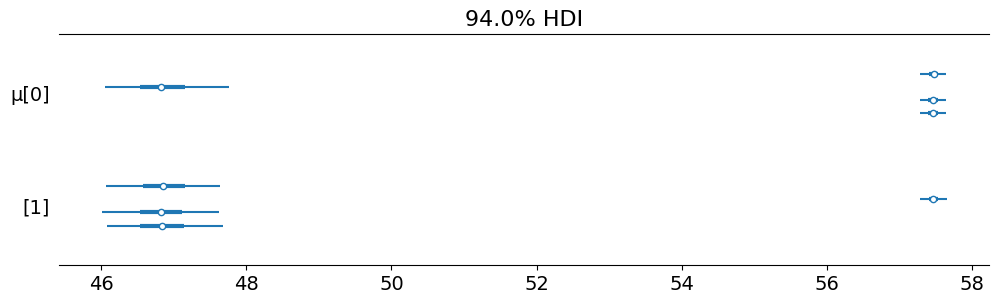

In [4]:
az.plot_forest(idata_mg, var_names="μ", figsize=(12, 3));

Notan algo raro en estos resultados? Tomensé un momento para pensarlo.

----

En la figura anterior podemos ver que para `μ[0]` una de las estimaciones está alrededor de 47 y las otras tres alrededor de 57.5. Y lo contrario para `μ[1]`, normalmente esperamos que las distintas cadenas nos den valores cercanos. Cuando los valores son muy diferentes sospechamos que el muestreo ha tenido problemas. Además si calcularamos la media de `μ[0]`, obtendremos un valor cercano a 55 ($57,5 \times 3 + 47 \times 1$), que no es el valor correcto. Lo que estamos viendo es un ejemplo de un fenómeno conocido como **no-identificabilidad** de parámetros. Esto sucede porque, desde la perspectiva del modelo, no hay diferencia si el componente 1 tiene una media de 47 y el componente 2 tiene una media de 57,5 o viceversa; ambos escenarios son equivalentes. En el contexto de los modelos mixtos, esto también se conoce como problema de cambio de etiqueta (label-switching).


## No-identificabilidad

Un modelo estadístico es no-identificable si uno o más de sus parámetros no pueden determinarse de forma única. Los parámetros de un modelo no se identifican si se obtiene la misma función de verosimilitud para más de un conjunto de parámetros. Esto puede suceder por que los datos no contengan suficiente información para estimar los parámetros o por que el modelo es estructuralmente no-identificable, lo que significa que los parámetros no pueden determinarse de manera única incluso si todos los datos necesarios están disponibles.

Con los modelos mixtos, existen al menos dos formas de parametrizar un modelo para eliminar el problema de la no identificabilidad. Podemos forzar un orden arbitrario en los componentes; por ejemplo, establecer que el vector $\mu$ debe ser estrictamente creciente o podemos usar priors informativos. La primer estrategia suele ser más general y simple de implementar y la segunda no garantiza la eliminación de problemas.

Usando PyMC, podemos implementar la primera opción con una transformación:

In [5]:
with pm.Model() as modelo_mgo:
    w = pm.Dirichlet('w', a=np.ones(K))
    μ = pm.Normal('μ', mu=cs_exp.mean(), sigma=10, shape=K,
                 transform=pm.distributions.transforms.ordered,
                 initval=np.array([cs_exp.mean()-1, cs_exp.mean()+1]),
                 )
    σ = pm.HalfNormal('σ', sigma=5)
    x = pm.NormalMixture('x', w=w, mu=μ, sigma=σ, observed=cs_exp)
    idata_mg = pm.sample(random_seed=123)    
    
    idata_mgo = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


## Como elegir K

Una de las principales preocupaciones con los modelos de mezclas finitas es cómo decidir el número de componentes. Una regla general es comenzar con una cantidad relativamente pequeña de componentes y luego aumentarla para el ajuste del modelo. Como ya vimos anteriormente el ajuste de un modelo se puede evaluar con una combinación de herramientas como las pruebas predictivas a posteriori, el ELPD y la experiencia de los modeladores.

Comparemos el modelo para $K = \{2, 3, 4, 5\}$

In [8]:
Ks = [2, 3, 4, 5]

models = []
idatas = []
for k in Ks:
    with pm.Model() as model:
        w = pm.Dirichlet('w', a=np.ones(k))
        μ = pm.Normal('μ',
                      mu=np.linspace(cs_exp.min(), cs_exp.max(), k),
                      sigma=cs_exp.var() / k, shape=k,
                      transform=pm.distributions.transforms.ordered,
                     )
        σ = pm.HalfNormal('σ', sigma=5)
        x = pm.NormalMixture('x', w=w, mu=μ, sigma=σ, observed=cs_exp)
        idata = pm.sample(random_seed=123,
                          idata_kwargs={"log_likelihood":True}
                         )
                         
        idatas.append(idata)
        models.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.


La siguiente figura muestra los modelos de mezcla para $K$ Gaussianas. La linea negra y solida representa la media a posteriori y las lineas turquesa muestras de la distribución a posterori. La distribución media de cada componente está representado usando lineas punteadas

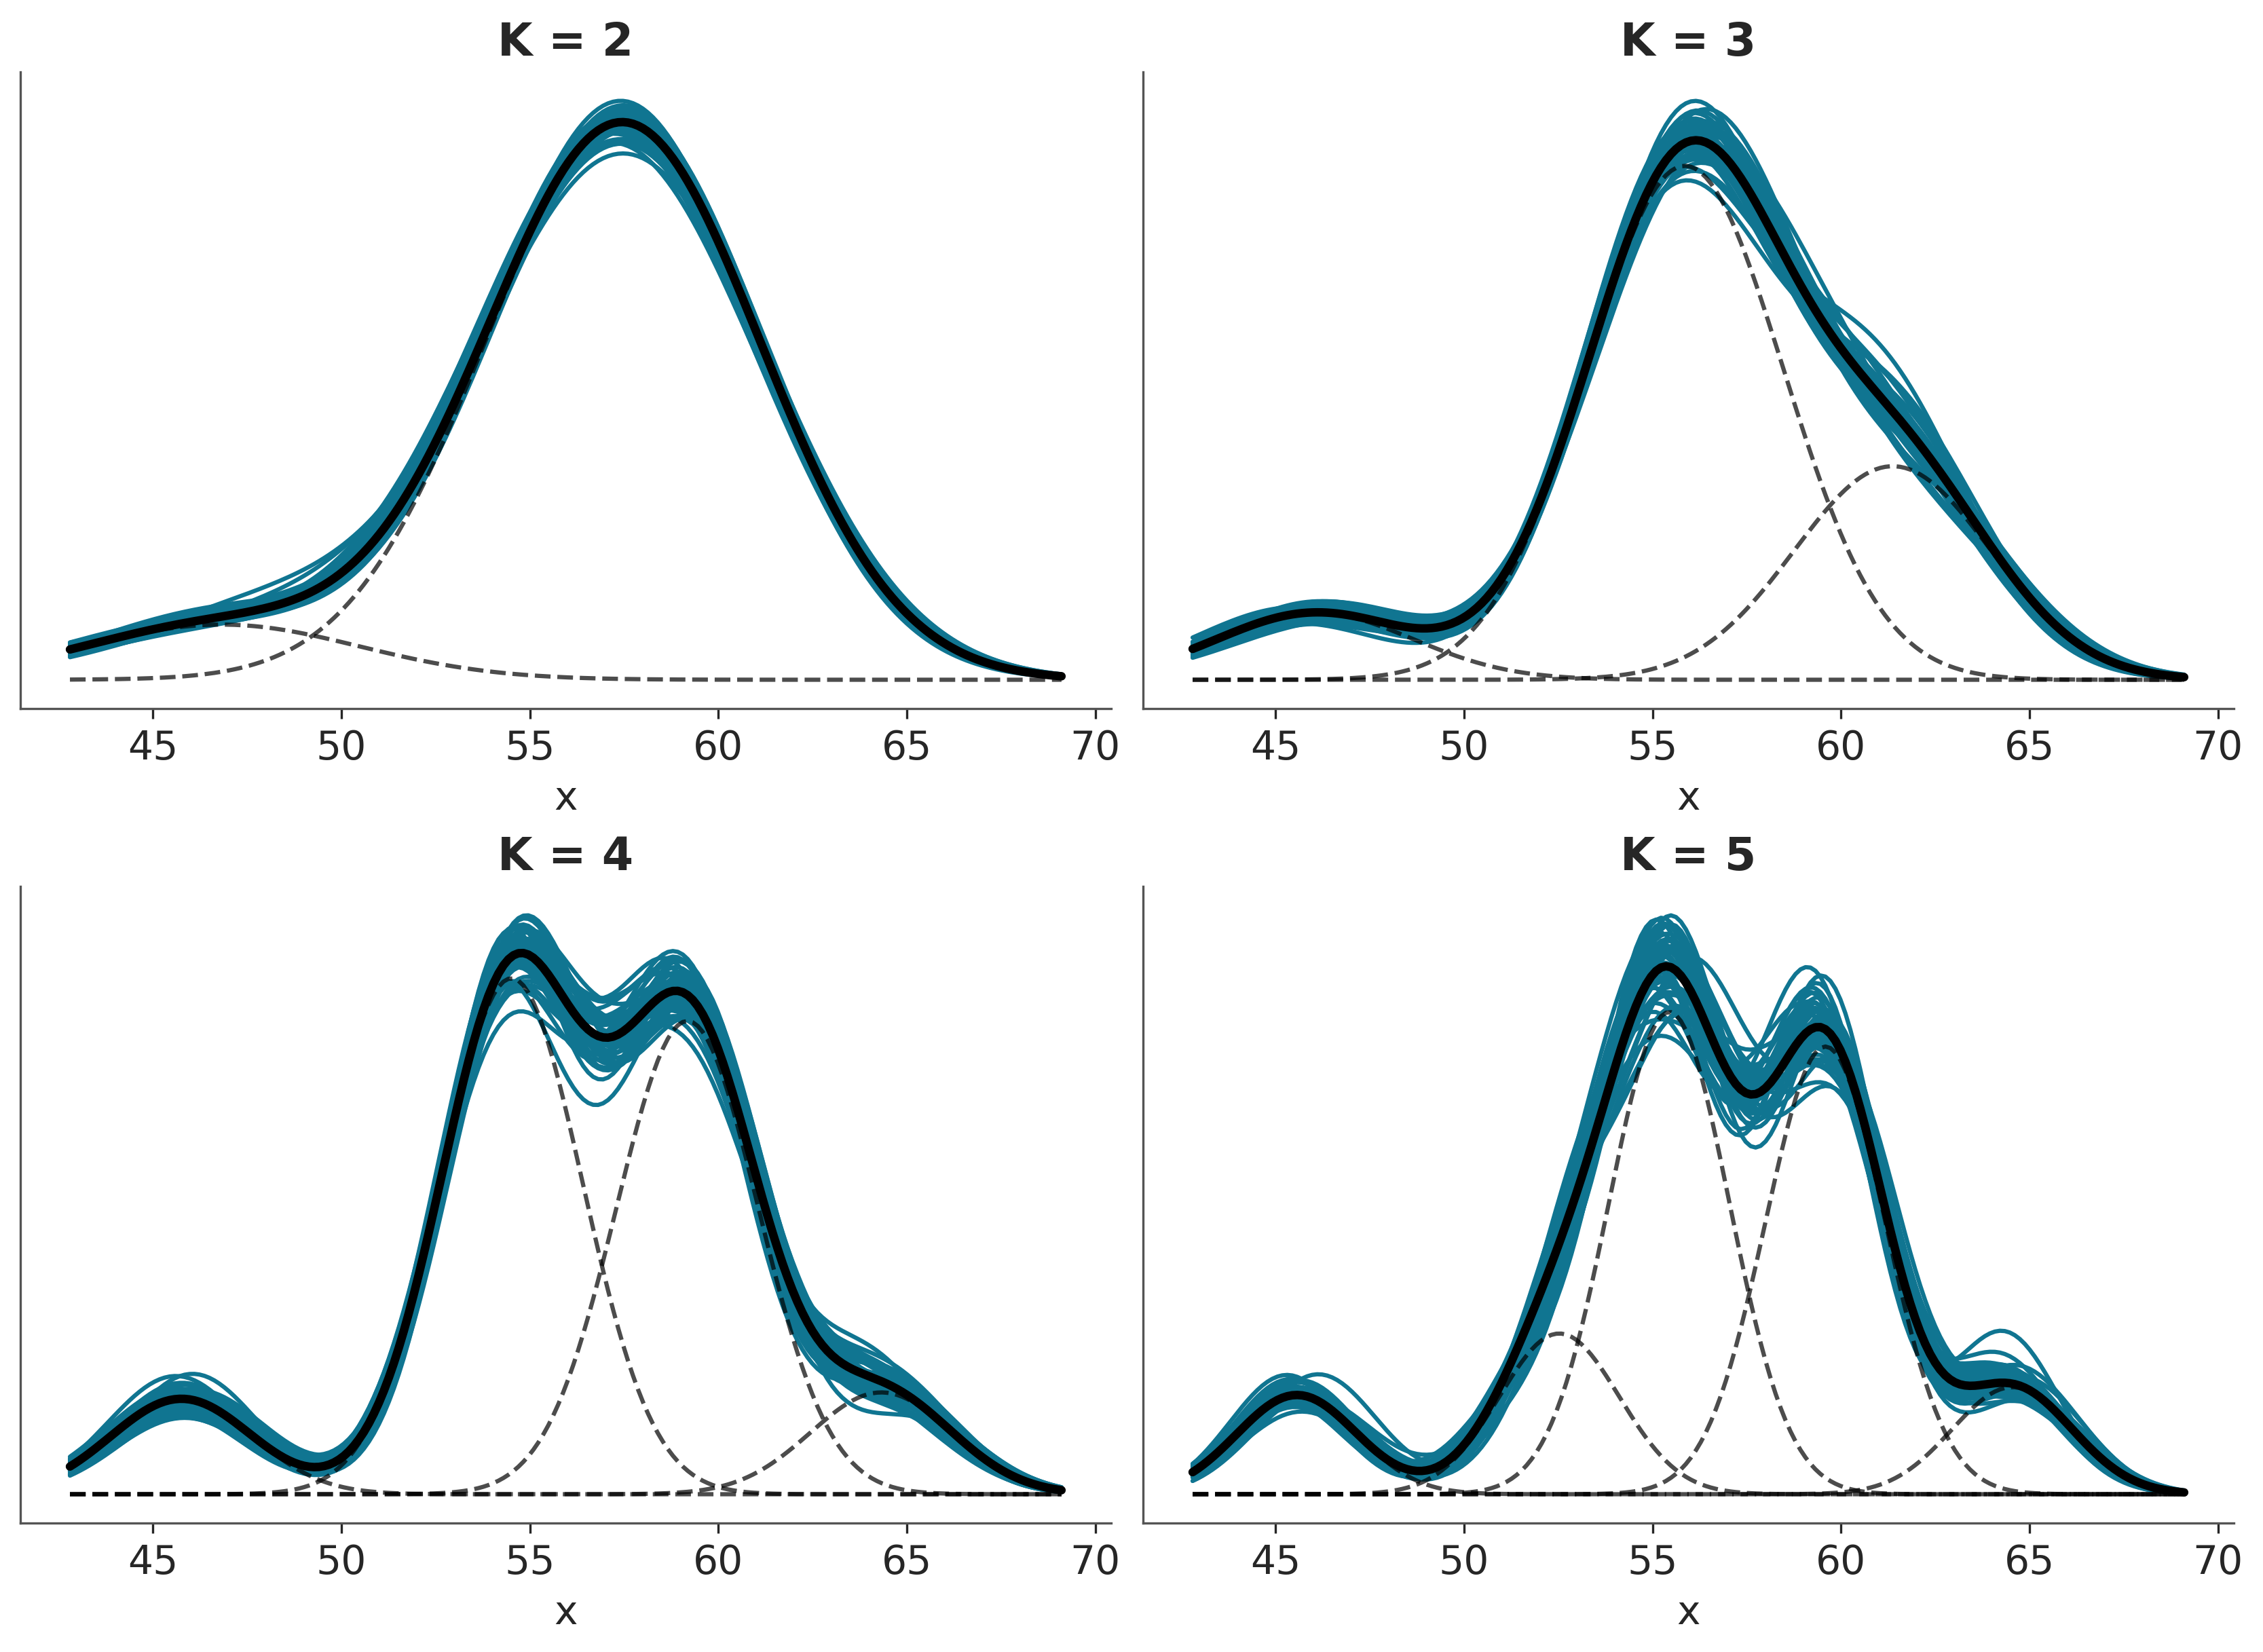

In [23]:
#| code-fold: true
_, ax = plt.subplots(2, 2, figsize=(11, 8))
 
ax = np.ravel(ax)
x = np.linspace(cs_exp.min(), cs_exp.max(), 200)
for idx, idata_x in enumerate(idatas):
    posterior_x = idata_x.posterior.stack(samples=("chain", "draw"))
    x_ = np.array([x] * Ks[idx]).T

    for i_ in np.random.randint(0, posterior_x.samples.size, size=50):
        dist = pz.Normal(posterior_x['μ'][:,i_], posterior_x['σ'][i_])
        ax[idx].plot(x, np.sum(dist.pdf(x_) *  posterior_x['w'][:,i_].values, 1), 'C1')
 
    p_y = posterior_x['w'].mean("samples")
    dist = pz.Normal(posterior_x['μ'].mean("samples"), posterior_x['σ'].mean())
    ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y.values, 1), 'k', lw=3)
    ax[idx].plot(x, dist.pdf(x_) * p_y.values, 'k--', alpha=0.7)
         
    ax[idx].set_title('K = {}'.format(Ks[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('x')

Visualmente, parece que $K=2$ es demasiado bajo, pero ¿cómo elegimos un valor mejor? 

Como ya hemos discutido, podemos usar pruebas predictivas a posteriori y calcular valores p bayesianos. La siguiente figura muestra un ejemplo de dicho cálculo y visualización. $K=5$ es la mejor solución y $K=4$ se acerca.

Sampling: [x]


Output()

Sampling: [x]


Output()

Sampling: [x]


Output()

Sampling: [x]


Output()

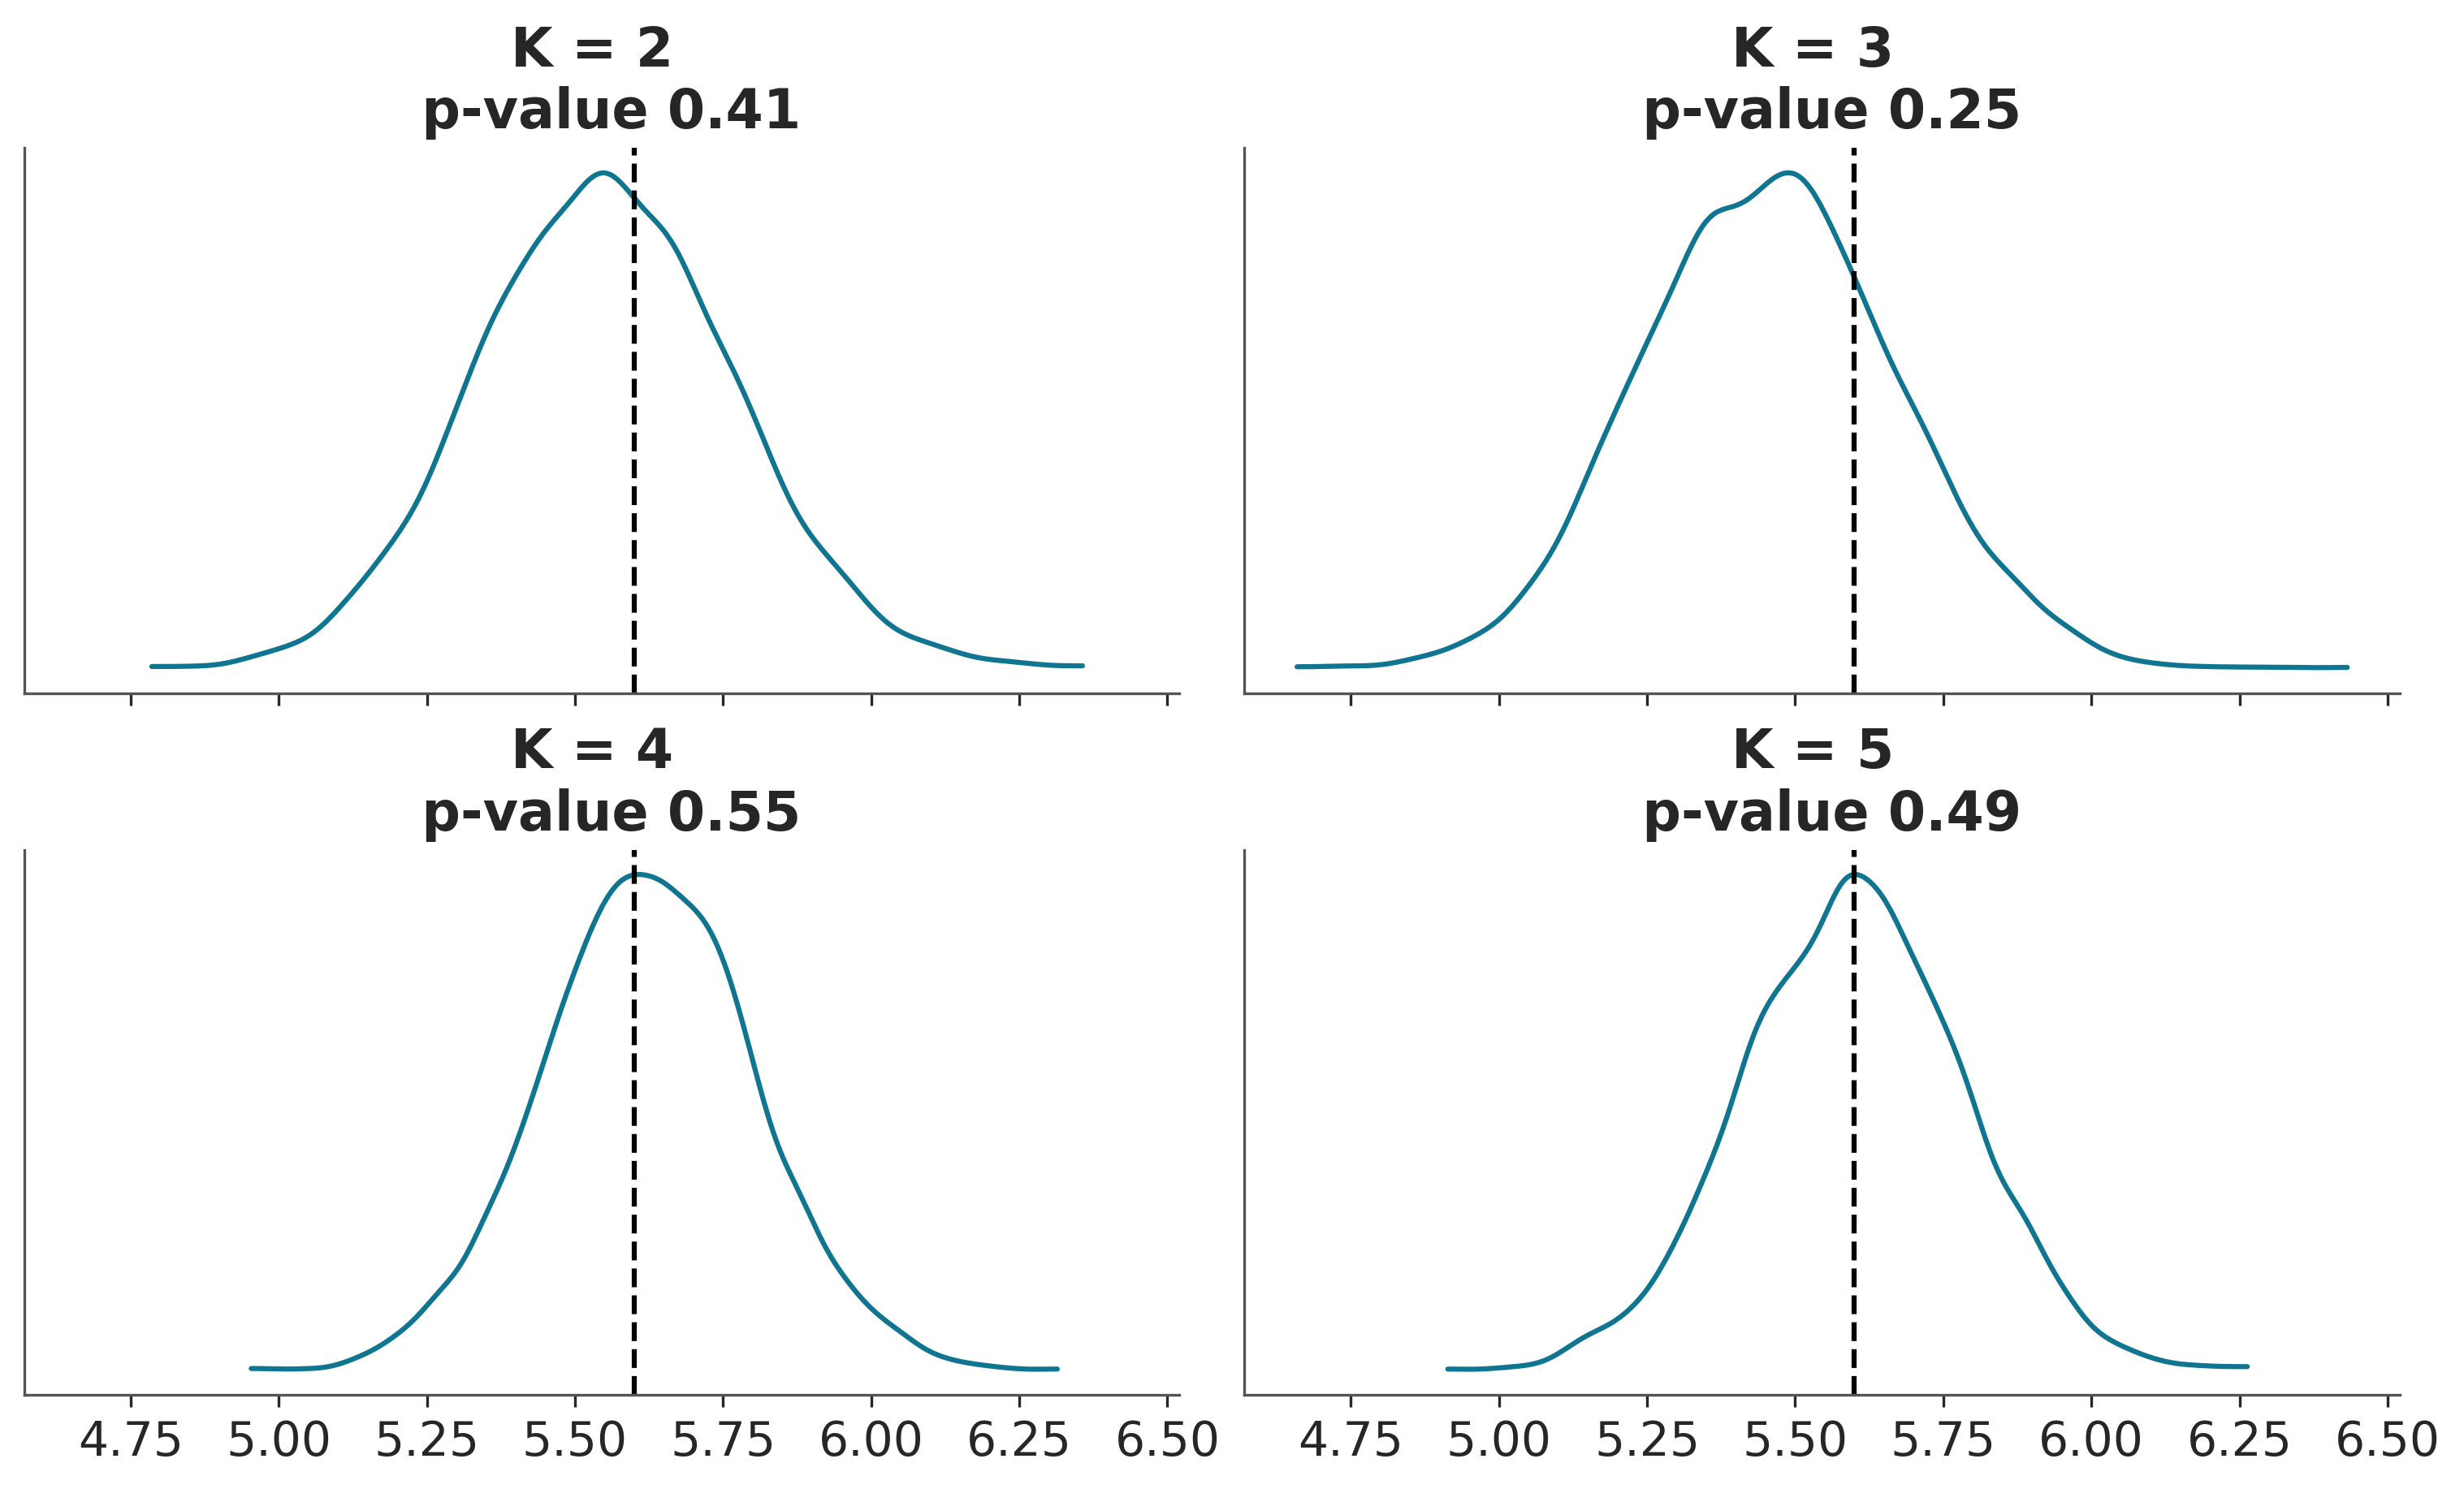

In [24]:
#| code-fold: true
ppc_mm = [pm.sample_posterior_predictive(idatas[i],
                                         models[i],
                                         random_seed=4591,
                                         progressbar=False) for i in range(4)]

fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
ax = np.ravel(ax)
def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))
    
T_obs = iqr(cs_exp)
for idx, d_sim in enumerate(ppc_mm):
    d_sim = d_sim.posterior_predictive["x"]
    T_sim = iqr(d_sim, 1)
    p_value = np.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, ax=ax[idx])
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    ax[idx].set_title(f'K = {Ks[idx]} \n p-value {p_value:.2f}')
    ax[idx].set_yticks([])

Para complementar las estas pruebas, podemos calcular el ELPD usando LOO. Podemos ver que los resultados coinciden con las pruebas predictivas

In [25]:
comp = az.compare(dict(zip([str(K) for K in Ks], idatas)))
comp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
5,0,-5129.318168,9.999541,0.000000,1.000000e+00,30.754122,0.000000,False,log
4,1,-5139.716879,7.721453,10.398712,0.000000e+00,31.256780,4.024542,False,log
3,2,-5178.298877,5.756020,48.980710,0.000000e+00,31.873449,8.809736,False,log
2,3,-5215.922884,3.260827,86.604716,2.227694e-10,33.483317,11.949417,False,log


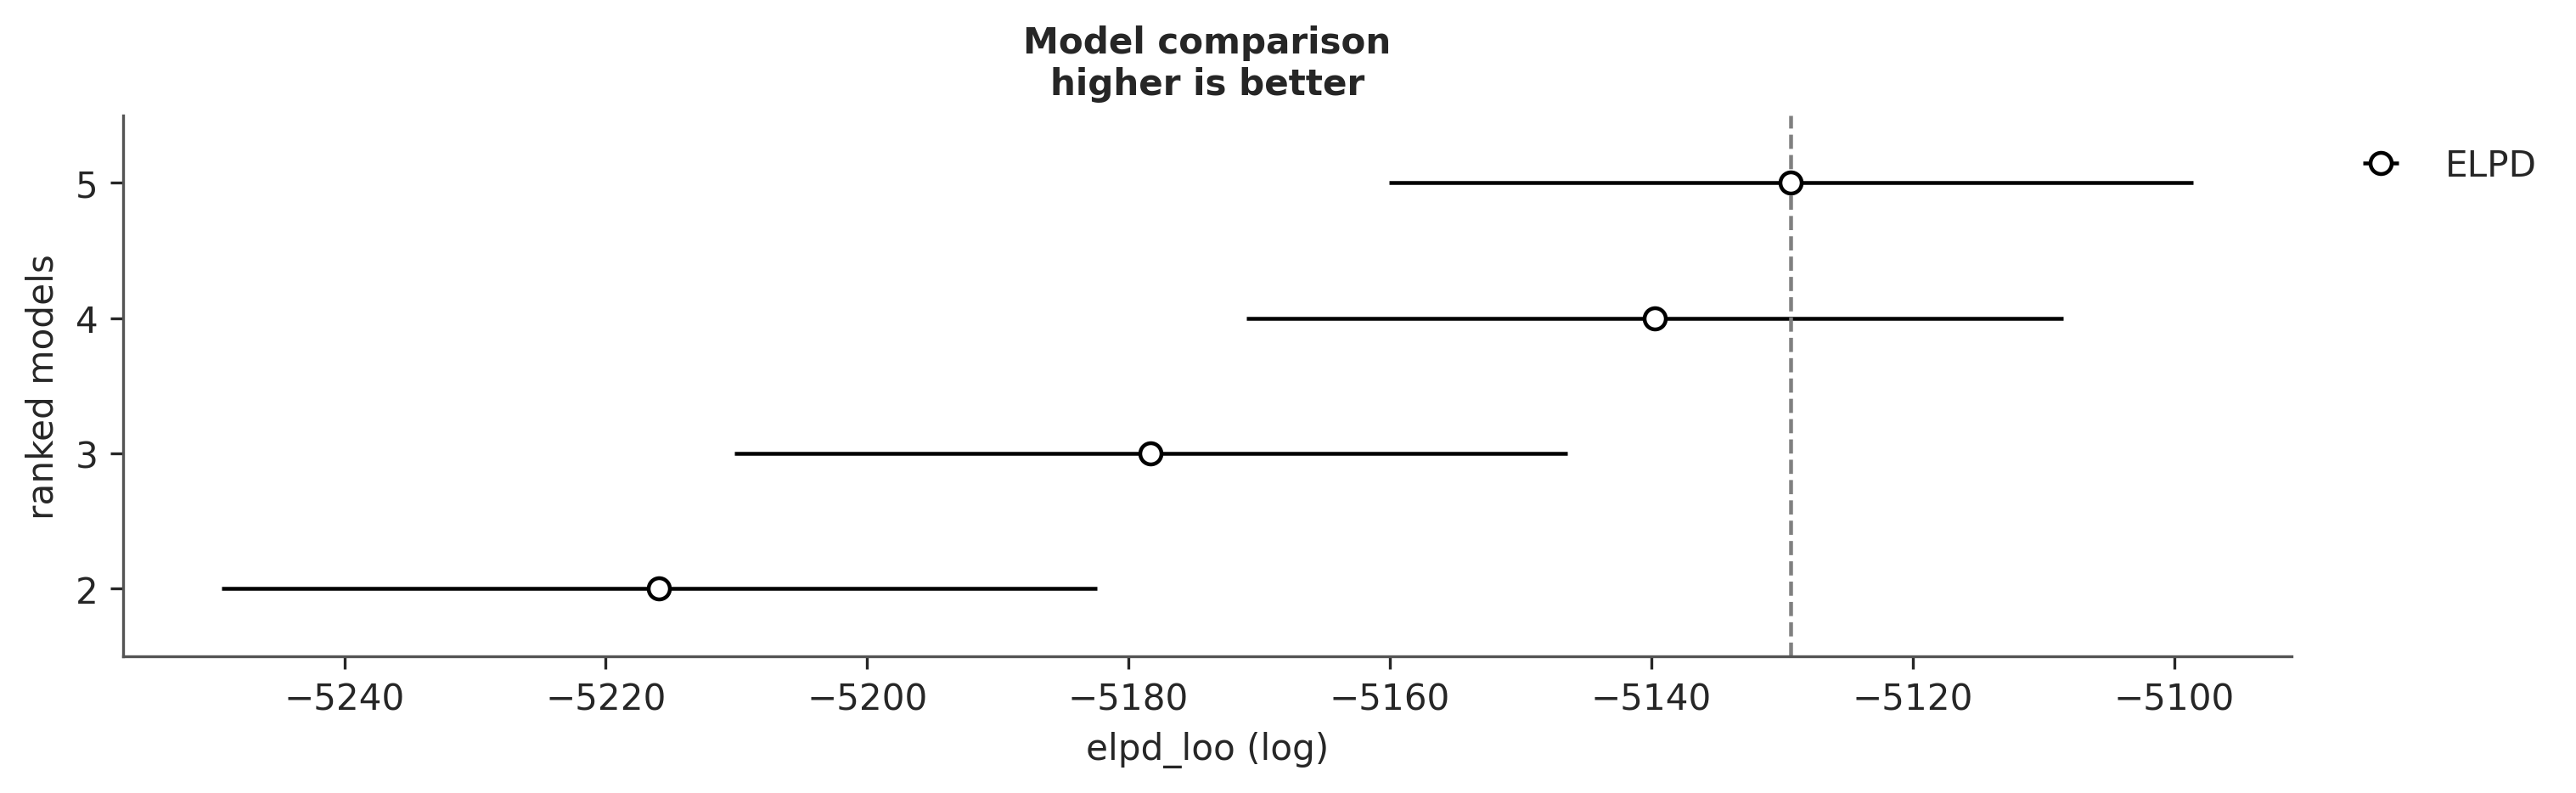

In [27]:
az.plot_compare(comp, figsize=(10, 3), plot_ic_diff=False);

El ejemplo de los desplazamientos químicos, aunque simple, muestra las ideas principales sobre los modelos de mezclas finitas. Para este ejemplo, utilizamos gaussianos porque proporcionan una buena aproximación para modelar los datos. Sin embargo, somos libres de utilizar componentes no gaussianos si es necesario. Por ejemplo, podríamos usar un:


* **Modelo de mezcla de Poisson**: suponga que está monitoreando la cantidad de clientes que ingresan a una tienda cada hora. Un modelo mixto de Poisson puede ayudar a identificar diferentes patrones de tráfico de clientes, como horas o días pico, suponiendo que los datos siguen una combinación de distribuciones de Poisson.
* **Modelo de mezcla exponencial**: Imagina que estás estudiando la vida útil de cierto tipo de bombilla. Un modelo de mezcla exponencial puede ayudar a identificar diferentes grupos de bombillas con diferentes vidas útiles, sugiriendo posibles diferencias en la calidad de fabricación o factores ambientales.


En la siguiente sección, exploraremos dos tipos muy particulares de modelos mixto.

## Modelos zero-inflados y modelos hurdle